# PROJECT 2: What kind of wine is this?

### Deliverables
1. Using the data available at `s3://ling583/wine-train.parquet` and `s3://ling583/wine-test.parquet`, construct a classifier that can predict wine variety labels on the basis of review texts. Try out different methods and see what works best. Evaluate your best model using the test data.

2. Find the words that your model is using to predict labels (either by looking at the model coefficients or by using a tool like LIME). What aspects of review texts is your model most sensitive to? Is there evidence of overfitting?

3. For Reuters texts, we found we could greatly increase the F1 score/accuracy by excluding items that that the model was most uncertain about. How many test examples would we have to exclude to achieve better than 0.85 F1 for this task?

4. Another way to improve accuracy is to change the labels. Use a confusion matrix to examine the patterns errors and propose a new labeling scheme. For example, if the model consistently labels “merlot” as “riesling” and vice versa, you might want to create a new label “merlot/riesling”. Is it possible to get better than 0.85 F1 using your classifier trained on a different set of labels?

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm 

tqdm.pandas()

## 1. Contruct a classifier to predict win variety labels 
### Load and preprocess data

In [291]:
train = pd.read_parquet(
    "s3://ling583/wine-train.parquet", storage_options={"anon": True}
)
test = pd.read_parquet(
    "s3://ling583/wine-test.parquet", storage_options={"anon": True}
)

In [3]:
# View a first few observations
train.head()

,review_text,wine_variant
0,Rich smoky dark cherry nose very intense fruit...,Pinot Noir
1,Had this at Corton Restaurant in NYC. First of...,Syrah
2,"Nose is very tart, with a layer of sweet fruit...",Pinot Noir
3,Beautiful golden color. Discrete perfumed nose...,Chardonnay
4,Please take the time to decant: you will not b...,Pinot Noir


In [4]:
test.head()

,review_text,wine_variant
0,hmmm. i have mixed emotions about this wine. o...,Chardonnay
1,You can find several dozen SB Syrahs that have...,Syrah
2,It has a nice even red finish and remote cherr...,Pinot Noir
3,"WIML91 Tasted October 6, 2009. Opened and se...",Pinot Noir
4,My last bottle with the super bowl. Sipped wit...,Zinfandel


In [5]:
len(train)

130497

In [6]:
len(test)

32625

##### Tokenize review text

In [7]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)

In [253]:
def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [292]:
train["tokens"] = train["review_text"].progress_apply(tokenize)
test["tokens"] = test["review_text"].progress_apply(tokenize)

  0%|          | 0/130497 [00:00<?, ?it/s]

  0%|          | 0/32625 [00:00<?, ?it/s]

In [226]:
train["wine_variant"].value_counts()

Pinot Noir            38471
Cabernet Sauvignon    30234
Chardonnay            19443
Syrah                 13704
Riesling               9683
Zinfandel              8327
Merlot                 5522
Sauvignon Blanc        5113
Name: wine_variant, dtype: int64

---

### Baseline Dummy Classifier 

In [11]:
# load all necessary modules
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5432) # 5-fold cross validation method 

In [13]:
baseline = DummyClassifier()
cross_val_score(baseline, train["tokens"], train["wine_variant"], cv=cv) # accuracy 

array([0.29482759, 0.29478927, 0.29480057, 0.29480057, 0.29480057])

In [14]:
predicted = cross_val_predict(baseline, train["tokens"], train["wine_variant"], cv=cv)
print(classification_report(train["wine_variant"], predicted))

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

Cabernet Sauvignon       0.00      0.00      0.00     30234
        Chardonnay       0.00      0.00      0.00     19443
            Merlot       0.00      0.00      0.00      5522
        Pinot Noir       0.29      1.00      0.46     38471
          Riesling       0.00      0.00      0.00      9683
   Sauvignon Blanc       0.00      0.00      0.00      5113
             Syrah       0.00      0.00      0.00     13704
         Zinfandel       0.00      0.00      0.00      8327

          accuracy                           0.29    130497
         macro avg       0.04      0.12      0.06    130497
      weighted avg       0.09      0.29      0.13    130497



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using the dummy classifier, the model doesn't look really good. It has an F1 accuracy score of 0.29 and a marco average of all the factors of 0.06, which is really low. We need to try a different model. 

--- 

### Bernoulli Naive Bayes

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline

In [16]:
# set up pipeline 
bnb = make_pipeline(CountVectorizer(analyzer=identity), BernoulliNB())

In [17]:
predicted = cross_val_predict(bnb, train["tokens"], train["wine_variant"], cv=cv, n_jobs=-1)
print(classification_report(train["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.60      0.84      0.70     30234
        Chardonnay       0.72      0.89      0.79     19443
            Merlot       0.70      0.03      0.05      5522
        Pinot Noir       0.75      0.85      0.80     38471
          Riesling       0.89      0.62      0.73      9683
   Sauvignon Blanc       0.93      0.37      0.54      5113
             Syrah       0.73      0.43      0.54     13704
         Zinfandel       0.86      0.39      0.53      8327

          accuracy                           0.71    130497
         macro avg       0.77      0.55      0.59    130497
      weighted avg       0.73      0.71      0.68    130497



This method Bernoulli Naive Bayes seems to have better fit results compared to dummay classifier. With a macro average score of F1 of .59, the model has a really balance score between each factor. However, let's try different models to see if we can find better ones.

---

### Multinomial Naive Bayes

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

In [19]:
# set up pipeline for multinomial naive bayes 
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5432)

In [21]:
predicted = cross_val_predict(mnb, train["tokens"], train["wine_variant"], cv=cv, n_jobs=-1)
print(classification_report(train["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.61      0.85      0.71     30234
        Chardonnay       0.80      0.86      0.83     19443
            Merlot       0.82      0.08      0.14      5522
        Pinot Noir       0.76      0.85      0.80     38471
          Riesling       0.85      0.72      0.78      9683
   Sauvignon Blanc       0.90      0.48      0.63      5113
             Syrah       0.72      0.48      0.58     13704
         Zinfandel       0.83      0.43      0.57      8327

          accuracy                           0.73    130497
         macro avg       0.79      0.59      0.63    130497
      weighted avg       0.75      0.73      0.71    130497



Fortunately, this model mutinomial Naive Bayes has better output compared to the binomial Naive Bayes. This model has an F1 accuracy score of .73, which is really high so far. In addition, the macro average score for F1 is also higher in this model compared to the binomial model. Therefore, we now assume that the Mutinomial Naive Bayes model would give us the best predictions. However, let's still try other models to see if we can find a better model. 

--- 

### SGD Classifier

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import make_pipeline

In [23]:
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd.fit(train["tokens"], train["wine_variant"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.71      0.79      0.75      7558
        Chardonnay       0.82      0.85      0.83      4861
            Merlot       0.62      0.36      0.45      1381
        Pinot Noir       0.73      0.89      0.80      9618
          Riesling       0.80      0.78      0.79      2421
   Sauvignon Blanc       0.91      0.61      0.73      1278
             Syrah       0.79      0.50      0.61      3426
         Zinfandel       0.85      0.53      0.65      2082

          accuracy                           0.75     32625
         macro avg       0.78      0.66      0.70     32625
      weighted avg       0.76      0.75      0.75     32625



Using a SGD Classifier, the output for the model is looking the best so far compared with the dummy classifier, binomial Naive Bayes, and multinomial Naive Bayes models. This model has an accuracy score of .75 and a macro average of .70 which is quite high so far. We will consider this model to be the best for now. But, let's try different methods to find better models. 

--- 
### Tfidf Transformer

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer

In [25]:
sgd_idf = make_pipeline(CountVectorizer(analyzer=identity), 
                        TfidfTransformer(), 
                        SGDClassifier())
sgd_idf.fit(train["tokens"], train["wine_variant"])
predicted_idf = sgd_idf.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted_idf))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.69      0.81      0.75      7558
        Chardonnay       0.78      0.87      0.82      4861
            Merlot       0.87      0.33      0.47      1381
        Pinot Noir       0.74      0.88      0.80      9618
          Riesling       0.82      0.71      0.76      2421
   Sauvignon Blanc       0.84      0.62      0.72      1278
             Syrah       0.77      0.49      0.60      3426
         Zinfandel       0.89      0.48      0.63      2082

          accuracy                           0.75     32625
         macro avg       0.80      0.65      0.69     32625
      weighted avg       0.76      0.75      0.74     32625



Unfortunately, after running the TFIDF Tranformer, the output of the model doesn't look as good as the SGD Classifier with lower accuracy scores and lower macro average scores. However, the results for this TFIDF Tranformer model is very similar to SGG Classifier by itself. Therefore, it might be worth while to explore the TFIDF and SGD Classifier model. 

--- 
### Truncated SVD

In [26]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random

In [27]:
svd = make_pipeline(CountVectorizer(analyzer=identity), 
                    TfidfTransformer(), 
                    TruncatedSVD(n_components=100),
                    SGDClassifier())

In [28]:
svd.fit(train["tokens"], train["wine_variant"])
predicted_svd = svd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted_svd))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.56      0.79      0.65      7558
        Chardonnay       0.58      0.83      0.69      4861
            Merlot       0.06      0.01      0.01      1381
        Pinot Noir       0.67      0.82      0.74      9618
          Riesling       0.67      0.34      0.45      2421
   Sauvignon Blanc       0.66      0.20      0.31      1278
             Syrah       0.61      0.10      0.17      3426
         Zinfandel       0.63      0.29      0.40      2082

          accuracy                           0.61     32625
         macro avg       0.56      0.42      0.43     32625
      weighted avg       0.60      0.61      0.56     32625



After looking at the results of the Truncated SVD, the model doesn't seem to be better than the SGD Classifier with a lower accuracy score of .61 and a lower macro average of .42. Therefore, we will still stick with the SGD Classifier to be the best model. Again, our SGD Classifier, now, has an F1 score accuracy of 0.75 and and F1 macro average of 0.70. In addition, the weighted average for SGD Classifier is .75 which is the largest number of correctly labelling.  

Now that we have tried several models and have found our best model type, SGD Classifier. However, the results of the regression still need some improvement. We will do hyperparameter to search for the best parameters for our classifier.  

--- 
### Hyperparameter search

In [29]:
import mlflow
from dask_ml.model_selection import RandomizedSearchCV
from logger import log_search
from scipy.stats.distributions import loguniform, randint, uniform

In [30]:
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

In [31]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34055")
client

Client Scheduler: tcp://127.0.0.1:34055 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.62 GB


In [32]:
mlflow.set_experiment("project-2")
sgd = make_pipeline(
    CountVectorizer(analyzer=identity), TfidfTransformer(), SGDClassifier()
)

In [33]:
# define base model first
sgd_base = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd_base.fit(train["tokens"], train["wine_variant"])
predicted_base = sgd_base.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted_base))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.68      0.83      0.75      7558
        Chardonnay       0.82      0.85      0.83      4861
            Merlot       0.68      0.35      0.46      1381
        Pinot Noir       0.81      0.83      0.82      9618
          Riesling       0.76      0.82      0.79      2421
   Sauvignon Blanc       0.85      0.63      0.73      1278
             Syrah       0.67      0.58      0.62      3426
         Zinfandel       0.80      0.54      0.65      2082

          accuracy                           0.76     32625
         macro avg       0.76      0.68      0.71     32625
      weighted avg       0.76      0.76      0.75     32625



In [34]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 20),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": loguniform(1e-6, 1e-2),
    },
    n_iter=50,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

CPU times: user 10.5 s, sys: 1.43 s, total: 12 s
Wall time: 6min 20s


We can inputting different parameters to see if we can get better results. 

In [35]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": loguniform(1e-8, 100),
    },
    n_iter=25,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

CPU times: user 9.94 s, sys: 1.35 s, total: 11.3 s
Wall time: 4min 20s


In [36]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": [0.1],
    },
    n_iter=25,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

CPU times: user 9.82 s, sys: 1.24 s, total: 11.1 s
Wall time: 3min 45s


### Compare optimized model to baseline

Getting results from MLflow that I have created. The best parameter with the best mean score of 0.71 have the following parameters: 
- `countvectorizer_min_df`: 1
- `countvectorizer_max_df`: 0.92
- `tfidftransformer_use_idf`: True
- `sgdclassifier__alpha`: 7e-06


In [37]:
sgd = make_pipeline(
    CountVectorizer(analyzer=identity, min_df=1, max_df=.92),
    TfidfTransformer(use_idf=True),
    SGDClassifier(alpha=7e-06),
)
sgd.fit(train["tokens"], train["wine_variant"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.70      0.81      0.75      7558
        Chardonnay       0.83      0.85      0.84      4861
            Merlot       0.82      0.34      0.48      1381
        Pinot Noir       0.77      0.87      0.82      9618
          Riesling       0.79      0.81      0.80      2421
   Sauvignon Blanc       0.84      0.66      0.74      1278
             Syrah       0.74      0.55      0.63      3426
         Zinfandel       0.80      0.54      0.65      2082

          accuracy                           0.76     32625
         macro avg       0.79      0.68      0.71     32625
      weighted avg       0.77      0.76      0.76     32625



In [38]:
base_f1 = f1_score(test["wine_variant"], predicted_base, average="macro")
sgd_f1 = f1_score(test["wine_variant"], predicted, average="macro")

In [39]:
base_f1, sgd_f1, sgd_f1 - base_f1

(0.7061027413984349, 0.7135274886642256, 0.0074247472657906766)

In [40]:
(sgd_f1 - base_f1) / (1 - base_f1)

0.025263070847000874

After optimizing the model for TFIDF Transform and SGD Clasifier. All metrics from the optimized model have the same outputs as the one from the baseline model. With an F1 accuracy score of 0.76, macro average of 0.71,and weighted average of 0.76, the baseline model SGD Classifer or the optimized model seem to be the best two models. However, the opmitized model is slightly better than the baseline model, just a little bit. Therefore, the final model we will use will be TFIDF Transform + SGD Classifier. To be sure, we can compare different model further. 

Use binomial test with a hypothesis of 50/50 chance of getting right or wrong predicted values. 

In [41]:
from scipy import stats

In [42]:
# compare if two classifier give different answers
# counting how many right/wrong
diff = (predicted == test["wine_variant"]).astype(int) - (
    predicted_base == test["wine_variant"]
).astype(int)
sum(diff == 1), sum(diff == -1), sum(diff == 0)

(947, 752, 30926)

In [43]:
stats.binom_test([sum(diff == 1), sum(diff == -1)], alternative="greater")

1.229611051836898e-06

The Binomial test has a really small p-value. This proves that a diviation from 50/50 is very small. There for the test is significant. 

Use Wilcoxon test to tet the sign of the predicted values. 

In [44]:
stats.wilcoxon(diff, alternative="greater")

WilcoxonResult(statistic=804950.0, pvalue=1.117983801152459e-06)

P-value is also very small for Wilcoxon test. Therefore, we conclude that the signs are correct. 

Therefore, the optimized model is clearly better than the baseline model.

#### Save the model

In [45]:
import cloudpickle

In [46]:
# feed in raw text instead of tokenized text and use tokenizes = tokenize parameter 
# get the same result 
sgd = make_pipeline(
    CountVectorizer(analyzer=identity, min_df=1, max_df=.92),
    TfidfTransformer(use_idf=True),
    SGDClassifier(alpha=7e-06),
)
sgd.fit(train["tokens"], train["wine_variant"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.70      0.81      0.75      7558
        Chardonnay       0.81      0.86      0.84      4861
            Merlot       0.79      0.34      0.47      1381
        Pinot Noir       0.77      0.87      0.81      9618
          Riesling       0.80      0.80      0.80      2421
   Sauvignon Blanc       0.84      0.66      0.74      1278
             Syrah       0.75      0.54      0.63      3426
         Zinfandel       0.85      0.52      0.65      2082

          accuracy                           0.76     32625
         macro avg       0.79      0.68      0.71     32625
      weighted avg       0.77      0.76      0.75     32625



In [47]:
cloudpickle.dump(sgd, open("sgd.model", "wb"))

--- 
## 2. Find the words that the model is using to predict labels 

In [48]:
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix
import matplotlib.pyplot as plt

In [49]:
# read model 
sgd = cloudpickle.load(open("sgd.model", "rb"))

#### Error 

In [52]:
err = test[(test['wine_variant']=='Pinot Noir')&(predicted=='Syrah')]
len(err)

176

In [53]:
err['review_text'].iloc[0]

"Gorgeous nose of ripe fruit and white pepper. On the palate, this is beautiful and youthful, with great acids and nice tannins which are largely integrate and a nice complement. Wonderful strawberries and great minerality. Wonderful. My #2 WOTN, Group's WOTN."

In [54]:
err['review_text'].iloc[1]

"Herbs and smoked cheese on the nose, after breathing for a bit it revealed some fruit and roasted meat flavors. Damn, wish i'd gotten to this two years ago. 45 bones."

In [55]:
err['review_text'].iloc[2]

'one of the last of night. meaty dark fruit nose. great weight in the mouth, very precise, just rolled through my mouth and gave taste and taste..great bottle'

The common words in this Pinot Noir labels and Syrah are fruity taste and fruity flavor. The algorithm could be very easily confused between the two types. 

In [56]:
err = test[(test['wine_variant']=='Pinot Noir')&(predicted=='Riesling')]
len(err)

59

In [57]:
err['review_text'].iloc[0]

'The nose is clearly oxidized but on the palate the quality shows through - sweet and dense wine. Such a shame the nose was so awful, this wine is a legend!'

In [58]:
err['review_text'].iloc[1]

"The nose is very mineraly with some dark fruit. It's light on the palate, with hints of citrus and minerals and raspberries. Very dry finish."

In [59]:
err['review_text'].iloc[2]

'Pretty floral this time. Matched up very nicely with Indian cuisine. I keep waiting for this one to close down for a while, but so far it is still all right there.'

These review texts also has some fruit, floral flavor in them, which could have been easily misclassified as a Pinot Noir. 

#### Model labels and coefficients

In [61]:
labels = sgd.named_steps['sgdclassifier'].classes_
scores = sgd.decision_function(test["review_text"])

View all the labels for the model and the coefficient for each model

In [62]:
labels

array(['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Pinot Noir',
       'Riesling', 'Sauvignon Blanc', 'Syrah', 'Zinfandel'], dtype='<U18')

In [63]:
scores[0,:]

array([-1.03799746, -1.18573332, -1.01243731, -0.18691811, -0.56845076,
       -1.21499175, -1.1016332 , -1.40907213])

In [67]:
highest = scores.max(axis=1)

In [68]:
highest.argmax()

2574

In [69]:
scores[2574]

array([-1.81886615, -0.94458217, -1.07995904,  0.24736993, -0.70534888,
       -1.20539673, -0.97741393, -1.46469992])

In [72]:
test['wine_variant'].iloc[2574]

'Cabernet Sauvignon'

In [73]:
test['review_text'].iloc[2574]

'Wow. Drink up. This wine is bursting with fruit after all these years. Fruit dominated strawberry and plum. Great wine.'

This is one example of the review text that would have the highest scores. These kinds of text would be the most sensitive to. As looking at the text, it is quite broard with the fruit flavor.  

We can look at the argmin example 

In [74]:
highest.argmin()

6104

In [75]:
scores[6104]

array([-1.04366066, -1.06128566, -1.1739224 , -0.93052976, -1.34586669,
       -1.30348086, -1.32688622, -1.23352915])

In [76]:
test['wine_variant'].iloc[6104]

'Cabernet Sauvignon'

In [77]:
test['review_text'].iloc[6104]

"LOST MOST OF IT'S OAK AFTER AN HOUR OR SO AND BECAME VERY WELL BALANCED W/ DARK RED FRUIT AND LEATHERY TOBACCO."

### 3. Improve F1 Score

In [85]:
scores[0:5,:]

array([[-1.03799746, -1.18573332, -1.01243731, -0.18691811, -0.56845076,
        -1.21499175, -1.1016332 , -1.40907213],
       [-1.14327201, -1.39103226, -1.10711436, -0.04917735, -0.51314788,
        -1.17378408, -1.10273248, -1.28258014],
       [-1.31091204, -1.25753694, -1.14355182, -0.03357089, -0.54624536,
        -1.19002576, -1.12713196, -1.46726075],
       [-1.38686013, -1.10907669, -1.17670792, -0.08945508, -0.77231138,
        -1.18292441, -0.98313824, -1.4566137 ],
       [-1.16743885, -1.24821853, -1.05984842, -0.06359701, -0.65494692,
        -1.04265347, -1.09804623, -1.40497275]])

In [133]:
scores.sort(axis=1)
scores[0:5,:]

array([[-1.40907213, -1.21499175, -1.18573332, -1.1016332 , -1.03799746,
        -1.01243731, -0.56845076, -0.18691811],
       [-1.39103226, -1.28258014, -1.17378408, -1.14327201, -1.10711436,
        -1.10273248, -0.51314788, -0.04917735],
       [-1.46726075, -1.31091204, -1.25753694, -1.19002576, -1.14355182,
        -1.12713196, -0.54624536, -0.03357089],
       [-1.4566137 , -1.38686013, -1.18292441, -1.17670792, -1.10907669,
        -0.98313824, -0.77231138, -0.08945508],
       [-1.40497275, -1.24821853, -1.16743885, -1.09804623, -1.05984842,
        -1.04265347, -0.65494692, -0.06359701]])

In [184]:
margin = scores[:,1] 

In [185]:
margin.max(), margin.min()

(-1.0510775657856943, -1.5958055170577996)

In [167]:
print(classification_report(test["wine_variant"][margin > -1.07], predicted[margin > -1.07]))

                    precision    recall  f1-score   support

Cabernet Sauvignon       1.00      1.00      1.00         1
        Chardonnay       1.00      1.00      1.00         1
            Merlot       1.00      1.00      1.00         1
          Riesling       1.00      1.00      1.00         1

          accuracy                           1.00         4
         macro avg       1.00      1.00      1.00         4
      weighted avg       1.00      1.00      1.00         4



In [170]:
print(classification_report(test["wine_variant"][margin > -1.075], predicted[margin > -1.075]))

                    precision    recall  f1-score   support

Cabernet Sauvignon       1.00      1.00      1.00         1
        Chardonnay       1.00      1.00      1.00         2
            Merlot       1.00      1.00      1.00         1
          Riesling       0.50      1.00      0.67         1
         Zinfandel       0.00      0.00      0.00         1

          accuracy                           0.83         6
         macro avg       0.70      0.80      0.73         6
      weighted avg       0.75      0.83      0.78         6



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


To get an F1 accuracy score of around .83, we have to use the margin of -1.075. Or if we increases the margin number to at least -1.075, then the accuracy score would be 1 as well as the macro average and weighted average. However, a model with perfect score would exclude a lot of test sample. Therefore, we still stick with .83 accuracy score. 

--- 
### 4. Assign New Labels 

Another way to improve accuracy is to change the labels. Use a confusion matrix to examine the patterns errors and propose a new labeling scheme. For example, if the model consistently labels “merlot” as “riesling” and vice versa, you might want to create a new label “merlot/riesling”. Is it possible to get better than 0.85 F1 using your classifier trained on a different set of labels?

#### Confusion Matrix 

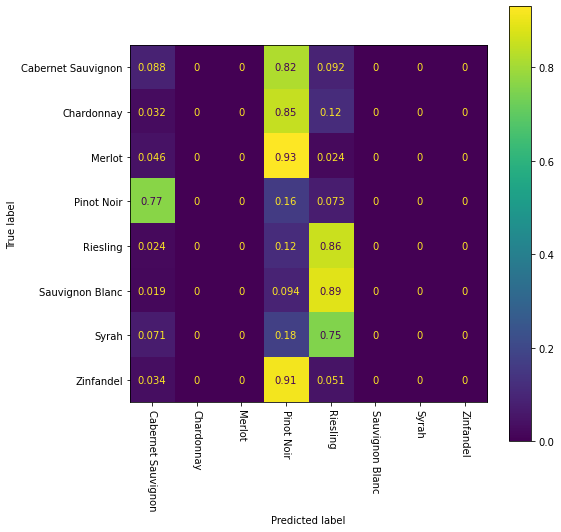

In [187]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sgd, test['wine_variant'], predicted, xticks_rotation=-90, normalize='true', ax=ax)
# how often label are confused with each other 
# the diagonal are the right label = true label are same as predited 

The highest proportion of misclassification are often occure with Pinot Noir, Cabenet Sauvignon, and Riesling. Here are the new label we would add to improve the model: 

In [310]:
train1 = train.copy()
test1 = test.copy()

In [311]:
m = train1['wine_variant'].isin(['Sauignon Blanc', 'Riesling'])
n = test1['wine_variant'].isin(['Sauignon Blanc', 'Riesling'])
train1['wine_variant'] = train1['wine_variant'].mask(m, 'Sauignon Blanc/Riesling')
test1['wine_variant'] = test1['wine_variant'].mask(n, 'Sauignon Blanc/Riesling')

In [314]:
m = train1['wine_variant'].isin(['Syrah', 'Cabernet Sauvignon'])
n = test1['wine_variant'].isin(['Syrah', 'Cabernet Sauvignon'])
train1['wine_variant'] = train1['wine_variant'].mask(m, 'Syrah/Cabernet Sauvignon')
test1['wine_variant'] = test1['wine_variant'].mask(n, 'Syrah/Cabernet Sauvignon')

In [315]:
# see all the topics 
train1["wine_variant"].value_counts()

Syrah/Cabernet Sauvignon    43938
Pinot Noir                  38471
Chardonnay                  19443
Sauignon Blanc/Riesling      9683
Zinfandel                    8327
Merlot                       5522
Sauvignon Blanc              5113
Name: wine_variant, dtype: int64

In [316]:
test1["wine_variant"].value_counts()

Syrah/Cabernet Sauvignon    10984
Pinot Noir                   9618
Chardonnay                   4861
Sauignon Blanc/Riesling      2421
Zinfandel                    2082
Merlot                       1381
Sauvignon Blanc              1278
Name: wine_variant, dtype: int64

Now we have less topic for the wine. We will generate the model again to see if we have higher F1 scores. 

#### Generate Classification 

In [317]:
sgd_new = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd_new.fit(train1["tokens"], train1["wine_variant"])
predicted_new = sgd_new.predict(test1["tokens"])
print(classification_report(test1["wine_variant"], predicted_new))

                          precision    recall  f1-score   support

              Chardonnay       0.84      0.84      0.84      4861
                  Merlot       0.85      0.34      0.48      1381
              Pinot Noir       0.80      0.83      0.82      9618
 Sauignon Blanc/Riesling       0.78      0.81      0.80      2421
         Sauvignon Blanc       0.89      0.62      0.73      1278
Syrah/Cabernet Sauvignon       0.75      0.87      0.81     10984
               Zinfandel       0.92      0.48      0.63      2082

                accuracy                           0.79     32625
               macro avg       0.83      0.69      0.73     32625
            weighted avg       0.80      0.79      0.79     32625



--- 
### Summary 

The raw review text for wine are kind of vauge, which cause the model algorithm to be unstable. A few models were generated to find the best model for this wine data set including dummy classifier, bernoulli Naive Bayes, multinoulli, SGD classifier, Tfidf Transformer, and truncated SVD. We found the best baseline model would be SGD classifier and Tfidf transformer. After optimizing the combination of SGD classifier + Tfidf transformer, we found the best parameters to generate the highest F1 accuracy scores of 0.75. 

However, after looking at the coefficients and labels of the model, we found that the model has been overfitted. There are alot of misclassification for the wine Pinot Noir and Cabernet Sauvignon label. To improve the model, we set the margin of the test set to exclude some of the sample. In addition, we also grouped the labels into different group so we can get a better output. The group we assigned were Sauignon Blanc/Riesling and Syrah/Cabernet Sauvignon since they have a lot of misclassification correlation. We would improve the model just by grouping them together. 

The final model have an accuracy F1 score of 0.79, which is really good compared to the baseline and optimized models. In addition, the macro average score is 0.73 and the weighted average is 0.79, which are better than the baseline and optimized models. Since the review text for this data set are too similar from labels to labels, it is a good idea to group them together to get better output. I also have tried different set of labels, but these two labels seem to be the best of all. Therefore, it is impossible to have an F1 score of .85 or better. The only way to get an F1 or better is to exclude some of the test sample.